In [1]:
import torch, cv2, copy, os
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Iterable
from torchvision.models.resnet import BasicBlock, Bottleneck
from data_preparation.dataset import FrameDataset
from model.architecture import GWDetectionNET
from metrics import GWDetectionCriterion
from pipelines import BBoxExclusiveTrainingPipeline, SegmentExclusiveTrainingPipeline, TrainingPipeline
from utils import prepare_img_and_bbox, draw_bbox_on_img
from matplotlib import pyplot as plt

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# torch.autograd.set_detect_anomaly(True)

In [2]:
GRAYSCALE = True

train_data_path = "data/Train_data"
validation_data_path = "data/Validation_data"
test_data_path = "data/Test_data"
img_size = (256, 256)

train_dataset = FrameDataset(train_data_path, grayscale=GRAYSCALE, img_loc="png", mask_loc="gt", size=img_size)
validation_dataset = FrameDataset(validation_data_path, grayscale=GRAYSCALE, size=img_size)
test_dataset = FrameDataset(test_data_path, grayscale=GRAYSCALE, size=img_size)

Sample Images (shape: torch.Size([1, 256, 256]))


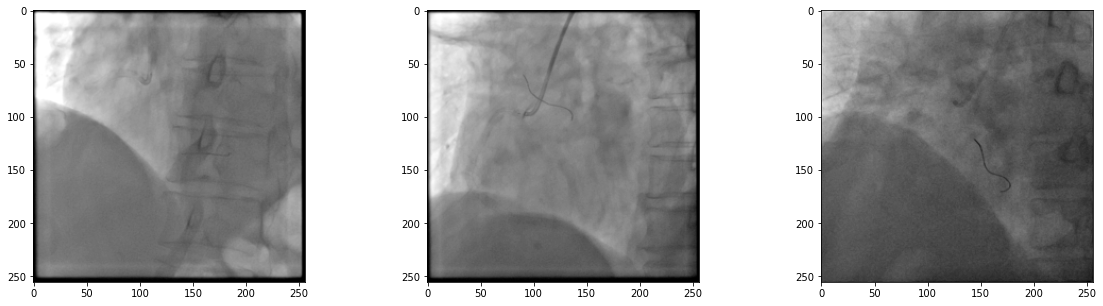

(256, 256, 1)

Sample Images with Bounding Boxes and Mask Segments


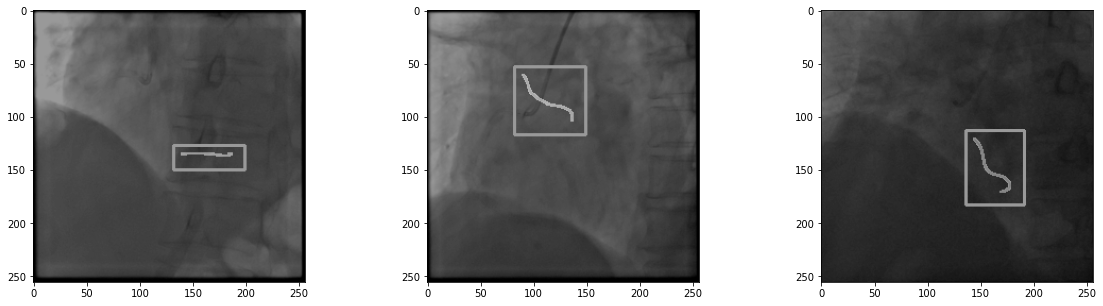

In [3]:
train_sample_img, train_sample_bbox, train_sample_mask = train_dataset[np.random.randint(0, len(train_dataset))]
val_sampl_img, val_sampl_bbox, val_sample_mask = validation_dataset[np.random.randint(0, len(validation_dataset))]
test_sample_img, test_sample_bbox, test_sample_mask = test_dataset[np.random.randint(0, len(test_dataset))]

format_img = lambda img : img.permute(1, 2, 0) if not GRAYSCALE else img.squeeze()

print(f"Sample Images (shape: {train_sample_img.shape})")
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(format_img(train_sample_img), cmap="gray")
axs[1].imshow(format_img(val_sampl_img), cmap="gray")
axs[2].imshow(format_img(test_sample_img), cmap="gray")
plt.show()

train_sample_img, train_sample_bbox = prepare_img_and_bbox(train_sample_img, train_sample_bbox)
val_sampl_img, val_sampl_bbox = prepare_img_and_bbox(val_sampl_img, val_sampl_bbox)
test_sample_img, test_sample_bbox = prepare_img_and_bbox(test_sample_img, test_sample_bbox)
bbox_train_sample_img = draw_bbox_on_img(train_sample_img, train_sample_bbox, grayscale=GRAYSCALE)
bbox_val_sampl_img = draw_bbox_on_img(val_sampl_img, val_sampl_bbox, grayscale=GRAYSCALE)
bbox_test_sample_img = draw_bbox_on_img(test_sample_img, test_sample_bbox, grayscale=GRAYSCALE)

print("\nSample Images with Bounding Boxes and Mask Segments")
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(bbox_train_sample_img, cmap="gray")
axs[0].imshow(train_sample_mask.squeeze(), alpha=0.4, cmap="gray")

axs[1].imshow(bbox_val_sampl_img, cmap="gray")
axs[1].imshow(val_sample_mask.squeeze(), alpha=0.4, cmap="gray")

axs[2].imshow(bbox_test_sample_img, cmap="gray")
axs[2].imshow(test_sample_mask.squeeze(), alpha=0.4, cmap="gray")
plt.show()

In [4]:
batch_size = 32
num_workers = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [5]:
# model params
in_channels = 1 if GRAYSCALE else 3
n_classes = 0
dropout = 0.2
block = Bottleneck # BasicBlock
block_layers = [3, 4, 6, 3]
pretrained_backbone = "resnet50" #resnet18
last_fmap_ch = 2048 #512
anchor_path = "anchors/anchors.json"

# loss function params
iou_threshold = 0.5

# optimizer params
lr = 1e-4
min_lr = 1e-6
weight_decay = 7e-6
betas = (0.9, 0.9999)
T_0 = 20
T_mult = 2

# pipeline params
device = "cuda" if torch.cuda.is_available() else "cpu"
model_folder = "saved_model"
model_name = f"gw_detection_model.pth.tar"

In [6]:
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
np.random.seed(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
model = GWDetectionNET(
    in_channels, 
    img_size=img_size,
    anchors_path=anchor_path, 
    n_classes=n_classes, 
    block=block, 
    block_layers=block_layers,
    pretrained_resnet_backbone=pretrained_backbone, 
    last_fmap_ch=last_fmap_ch,
    use_locnet=True,
    use_segnet=True
    )
bbox_lossfunc = GWDetectionCriterion(iou_threshold=iou_threshold)
mask_lossfunc = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

# training pipeline
train_pipeline = TrainingPipeline(
    model=model, 
    bbox_lossfunc=bbox_lossfunc,
    mask_lossfunc=mask_lossfunc,
    optimizer=optimizer,
    device=device, 
    dirname=model_folder, 
    filename=model_name,
)

# lr scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    train_pipeline.optimizer, T_0=T_0, T_mult=T_mult, eta_min=min_lr, verbose=True,
)

Epoch 00000: adjusting learning rate of group 0 to 1.0000e-04.


In [8]:
epochs = 60

import warnings
warnings.filterwarnings("ignore")

best_total_loss = np.inf

for epoch in range(epochs):
    print(f"epoch: {epoch+1} / {epochs}")
    train_pipeline.train(train_dataloader, verbose=True)
    _, _, _, val_total_loss, _ = train_pipeline.evaluate(validation_dataloader, verbose=True)
    lr_scheduler.step()
    
    if val_total_loss < best_total_loss:
        best_total_loss = val_total_loss
        train_pipeline.save_model()
        print(f"model saved at epoch {epoch}, with total loss of {round(best_total_loss, 4)}")
    print("-"*130)

train_pipeline.plot_metrics("train")
train_pipeline.plot_metrics("eval")

epoch: 1 / 60


KeyboardInterrupt: 

In [ ]:
#train_pipeline.load_model()  # load best saved model

for i in range(5):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Actual Labels
    sample_image, sample_bbox, sample_mask = test_dataset[np.random.randint(0, len(test_dataset))]
    processed_sample_img, processed_sample_bbox = prepare_img_and_bbox(sample_image, sample_bbox)
    bbox_sample_img = draw_bbox_on_img(processed_sample_img.copy(), processed_sample_bbox, grayscale=GRAYSCALE)

    axs[0].imshow(bbox_sample_img, cmap="gray")
    axs[0].imshow(sample_mask.squeeze(), alpha=0.2, cmap="Oranges")
    axs[0].set_title("Actual Guide Wire Location")

    with torch.no_grad():
        pred_bbox, pred_mask = train_pipeline.model(sample_image.to(device).unsqueeze(dim=0))
    pred_bbox = pred_bbox.squeeze().cpu()
    confidence_score = pred_bbox[:, 0].max().item()
    pred_bbox = pred_bbox[pred_bbox[:, 0] == confidence_score].squeeze()
    pred_mask = pred_mask.squeeze().cpu()
    processed_sample_img, processed_pred_bbox = prepare_img_and_bbox(sample_image, pred_bbox)
    bbox_pred_img = draw_bbox_on_img(processed_sample_img, processed_pred_bbox, grayscale=GRAYSCALE)

    axs[1].imshow(bbox_pred_img, cmap="gray")
    axs[1].imshow(pred_mask.squeeze(), alpha=0.2, cmap="Oranges")
    axs[1].set_title(f"Predicted Guide Wire Location (confidence: {round(confidence_score, 4)})")
    plt.show()